# Install package

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)




Fri Dec 23 22:50:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# run the notebook through google colab
!pip install mat4py
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
from mat4py import loadmat
from tensorflow import keras
import time


In [ ]:
!python --version

Python 3.8.16


# Environment Setup

In [ ]:
#  Environment of the Frequency Control Porblem
class Frequency():
    def  __init__(self, Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.M=M
        self.D=D
        self.Pm=Pm
        self.max_action=max_action
        self.dim_action=dim_action
        self.omega_scale=2*np.pi
        self.state=[]
        self.delta_t=delta_t
        self.Penalty_action=Penalty_action
        self.state_transfer1=np.vstack((np.hstack((np.identity(dim_action,dtype=np.float32),np.zeros((dim_action,dim_action),dtype=np.float32))),\
                                np.hstack((delta_t*self.omega_scale*np.identity(dim_action,dtype=np.float32),\
                                           np.identity(dim_action,dtype=np.float32)-delta_t*np.diag(D/M)))))

        self.state_transferF=-delta_t*(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype=np.float32))*F
        self.state_transfer2=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        np.identity(dim_action,dtype=np.float32)))        

        self.state_transfer3=np.hstack((np.zeros((1,dim_action),dtype=np.float32),\
                                        delta_t*Pm*(M**(-1))))
        self.state_transfer3_Pm=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        delta_t*np.diag((M**(-1)))))
        self.state_transfer4=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        -delta_t*np.diag((M**(-1)))))

        self.select_add_w=np.vstack((np.zeros((dim_action,1),dtype=np.float32),\
                                        np.ones((dim_action,1),dtype=np.float32)))
        self.select_w=np.vstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        np.identity(dim_action,dtype=np.float32)))
        self.select_delta=np.vstack((np.identity(dim_action,dtype=np.float32),\
                                        np.zeros((dim_action,dim_action),dtype=np.float32)))
        

    def step(self, action,Pm):

        self.state=self.state@self.state_transfer1\
              + np.sum(np.sin( np.transpose(self.state@self.select_delta)@np.ones((1,dim_action),dtype=np.float32)-\
                np.ones((dim_action,1),dtype=np.float32)@(self.state@self.select_delta))*self.state_transferF,axis=1 )\
                      @self.state_transfer2\
              + Pm@self.state_transfer3_Pm\
                          +action@self.state_transfer4
        loss = self.param_gamma*pow(self.state,2)@self.select_add_w 
        return self.state, loss
    
    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        initial_state1=np.random.uniform(0.0,0.3,(1,self.dim_action))
        initial_state2=np.random.uniform(-0.03,0.03,(1,self.dim_action))
        s_concate=np.hstack((initial_state1,initial_state2)).astype(np.float32)
        self.state = s_concate

        return self.state

    


In [ ]:
# Simulation data load from IEEE 39-bus system
data = loadmat('IEEE_39bus_Kron_new.mat') # the path needs to be changed according to its location

K_EN = data['Kron_39bus']['K']
K_EN = np.asarray(K_EN, dtype = np.float32)

H = data['Kron_39bus']['H']
H = np.asarray(H, dtype = np.float32)

Damp = data['Kron_39bus']['D']
Damp = np.asarray(Damp, dtype = np.float32)

omega_R = data['Kron_39bus']['omega_R']

A_EN = data['Kron_39bus']['A']
A_EN = np.asarray(A_EN, dtype = np.float32)

gamma = data['Kron_39bus']['gamma']
gamma = np.asarray(gamma, dtype = np.float32)

In [ ]:
dim_action = 10 #dimension of action space
dim_state = 2*dim_action #dimension of state space
delta_t = 0.01
M = H.reshape(dim_action)*2/omega_R*2*np.pi #multiply with 2\pi to make unit in Hz
# D = Damp.reshape(dim_action)/omega_R*2*np.pi
# Here use the D data from P. Demetriou, M. Asprou, J. Quiros-Tortos, and E. Kyriakides, “Dynamic ieee test systems for transient analysis,”
D = np.zeros(dim_action,dtype = np.float32)
D[0] = 2*590/100
D[1:8] = 2*865/100
D[8:10] = 2*911/100;
D = D/omega_R*2*np.pi
F = K_EN
Penalty_action = 0.02*0.2
Pm = np.array([[-0.19983394, -0.25653884, -0.25191885, -0.10242008, -0.34510365,
         0.23206371,  0.4404325 ,  0.5896664 ,  0.26257738, -0.36892462]],dtype = np.float32)

max_action = np.array([[0.19606592, 0.2190382 , 0.22375287, 0.0975513 , 0.29071101,
        0.22091283, 0.38759459, 0.56512538, 0.24151538, 0.29821917]],dtype = np.float32)
equilibrium_init = np.array([[ -0.05420687, -0.07780334, -0.07351729, -0.05827823, -0.09359571,
        -0.02447385, -0.00783582,  0.00259523, -0.0162409 , -0.06477749,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.       ]],dtype = np.float32)
env  =  Frequency(Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action)


array([[0.19606592, 0.2190382 , 0.22375287, 0.0975513 , 0.29071102,
        0.22091283, 0.38759458, 0.5651254 , 0.24151538, 0.29821917]],
      dtype=float32)

# Init Simulation

In [ ]:
#linear droop control
def Action_linear(state,linear_coff,env):
    action_nonconstrain=(state@env.select_w)*linear_coff
    action=env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action


In [ ]:
linear_coff=np.array([[ 2.2347659,   2.720281 ,   2.4595585,  43.59709  ,   5.7675405,
          2.3880444, 156.02136  ,  12.0558605,   2.8042254,  25.922562  ]], dtype=np.float32)
action_units=dim_action

array([[-0.03088753, -0.04709371, -0.13456696, -0.05749901, -0.0542229 ,
        -0.0909659 , -0.03895541,  0.01435096,  0.03744669, -0.13253292,
        -0.15152116,  0.1421401 ,  0.18889686, -0.08573821, -0.10192593,
        -0.10905314, -0.11348901,  0.04800785,  0.16542184,  0.02915874]],
      dtype=float32)

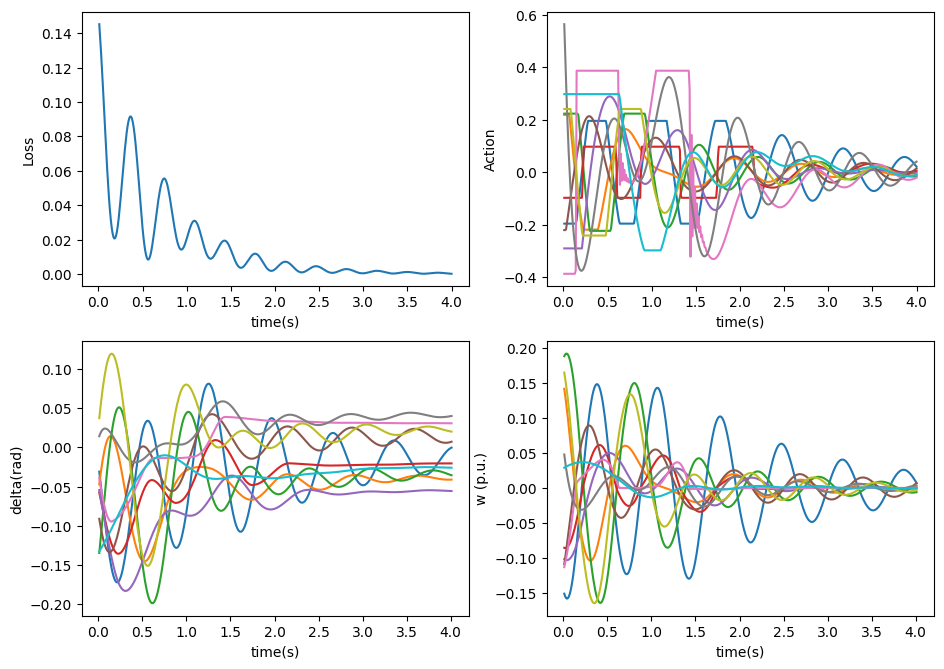

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[] 
initial_state1=np.random.uniform(-0.1,0.1,(1,dim_action))*1
initial_state2=np.random.uniform(-0.2,0.2,(1,dim_action))*1
s_concate=np.hstack((initial_state1,initial_state2)).astype(np.float32)

init_state=equilibrium_init+s_concate

s=init_state
env.set_state(s)
Trajectory_Linear.append(s)
SimulationLength=400
Record_u_Linear=[]
Record_Loss_Linear=[]
Loss_Linear=0
for i in range(SimulationLength):
    u=np.squeeze(Action_linear(s,linear_coff,env))
    next_s, r= env.step(u,Pm)
    Loss_Linear+=r
    s=next_s
    Trajectory_Linear.append(s)
    Record_u_Linear.append(u)
    Record_Loss_Linear.append(np.squeeze(r))

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss_Linear)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')
plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_Linear[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_Linear[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')
init_state

# RNN

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = action_units*2
        self.internal_units = internal_units
        self.batchsize = batchsize
        self.state_transfer1 = tf.constant(env.state_transfer1,dtype = tf.float32)
        self.state_transferF = tf.constant(env.state_transferF,dtype = tf.float32)
        self.state_transfer2 = tf.constant(env.state_transfer2,dtype = tf.float32)
        self.state_transfer3 = tf.constant(env.state_transfer3,dtype = tf.float32)
        self.state_transfer4 = tf.constant(env.state_transfer4,dtype = tf.float32)
        self.state_transfer3_Pm = tf.constant(env.state_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        self.Multiply_ones = tf.tile(tf.ones((action_units,action_units),dtype = np.float32)[None], [batchsize, 1, 1]) 
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        self.ones_frequency = tf.ones((action_units,internal_units),dtype = tf.float32)

        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_plus_temp0 =  self.add_weight(
            shape = (self.action_units,self.internal_units),
            initializer = 'uniform',
            trainable = True,
            name = 'w_plus_temp')

        self.b_plus_temp0 = self.add_weight(
            shape = (self.action_units,self.internal_units),
            initializer = tf.keras.initializers.RandomUniform(minval = 0, maxval = 0.1),
            trainable = True,
            constraint = tf.keras.constraints.MaxNorm(0.2),
            name = 'b_plus_temp')
        self.w_minus_temp0 =  self.add_weight(
            shape = (self.action_units,self.internal_units),
            initializer = 'uniform',
            trainable = True,
            name = 'w_minus_temp')

        self.b_minus_temp0 = self.add_weight(
            shape = (self.action_units,self.internal_units),
            initializer = tf.keras.initializers.RandomUniform(minval = 0, maxval = 0.1),
            trainable = True,
            constraint = tf.keras.constraints.MaxNorm(0.2),
            name = 'b_minus_temp')
        self.built = True

    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_output = states[0]
        w_plus_temp = tf.math.square(self.w_plus_temp0)
        b_plus_temp = tf.math.square(self.b_plus_temp0)
        w_minus_temp = tf.math.square(self.w_minus_temp0)
        b_minus_temp = tf.math.square(self.b_minus_temp0)
        w_plus = K.dot(w_plus_temp,self.w_recover)
        b_plus = K.dot(-b_plus_temp,self.b_recover)
        w_minus = K.dot(-w_minus_temp,self.w_recover)
        b_minus = K.dot(-b_minus_temp,self.b_recover)

        nonlinear_plus = K.sum(K.relu(K.dot(tf.linalg.diag(K.dot(prev_output,self.select_w)),self.ones_frequency)+b_plus)\
                        *w_plus,axis = 2)  
        nonlinear_minus = K.sum(K.relu(-K.dot(tf.linalg.diag(K.dot(prev_output,self.select_w)),self.ones_frequency)+b_minus)\
                        *w_minus,axis = 2)  

        action_nonconstrain =  nonlinear_plus+nonlinear_minus
        action = self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        # integrate the state transition dynamics
        new_state = K.dot(prev_output, self.state_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF,axis = 2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3+K.dot(action,self.state_transfer4)\
                             + inputs@self.state_transfer3_Pm


        loss0 = K.dot(K.pow(new_state,2),self.select_add_w)
        frequency = K.dot(new_state,self.select_w)

        
        return [loss0,frequency,action], [new_state]




In [ ]:
start = time.time()

episodes  = 600 # total number of iterations to update weights
action_units = dim_action
units = action_units #dimension of each state
internal_units = 20 # demension of the neural network for control policy
T = 200  #Total period considered
Batch_num = 600 # number of batch in each episodes
cell = MinimalRNNCell(units,action_units,internal_units,env,Batch_num)
layer = RNN(cell,return_sequences = True,stateful = True)
input_1 = tf.keras.Input(batch_shape = (Batch_num,T,units))
outputs = layer((input_1))
model = tf.keras.models.Model([input_1], outputs)
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x0 = np.ones((Batch_num,T,units))
y0 = model(x0)
Loss_record = []
Pe_rnn_record = []
global_step = tf.Variable(0, trainable = False)
learning_rate_initial = 0.05
decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 30, 0.7, staircase = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

PrintUpdate = 1
delta_rnn_init_bound = 0.05*0
omega_rnn_init_bound = 0.1*0 #in Hz
num_gen_step = 3
Percent_step_change = 1
range_step_change = 1
for i in range(0,episodes):
    ### train with trajectories from random initial states  
    # initial_state1 = np.random.uniform(-delta_rnn_init_bound,delta_rnn_init_bound,(Batch_num,action_units))
    # initial_state2 = np.random.uniform(-omega_rnn_init_bound,omega_rnn_init_bound,(Batch_num,action_units))
    # initial_state = np.hstack((initial_state1,initial_state2))+equilibrium_init
    ###  train with trajectories subject to step load changes    
    initial_state = np.zeros((Batch_num,action_units*2))+equilibrium_init
    Pm_change = np.zeros((Batch_num,T,units))
    for gen_interupt in range(0, num_gen_step):
        idx_gen_deviation = np.random.randint(0, action_units, Batch_num*Percent_step_change)
        idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
        slot_start_deviation = np.random.randint(0, T/2, Batch_num*Percent_step_change)  
        step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change    
        for t_interupt in range(0,T):
            Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                            = (slot_start_deviation> = t_interupt)*step_change

    layer.reset_states( initial_state)
    with tf.GradientTape(persistent = True) as tape:
        [loss0,frequency,action] = model(Pm_change)
        loss_action = env.Penalty_action*K.sum(K.abs(action))/Batch_num
        loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num
        loss = loss_action + loss_freq

    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))  
    Loss_record.append(loss)
    if i % (PrintUpdate) = =  0:
        print('episode',i, 'Loss',loss)
        print('episode',i, 'Loss_frequency',loss_freq)

end = time.time()
print(end - start)    

Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

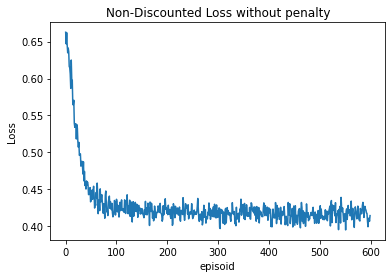

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

In [ ]:
# model.save_weights('weights_RNN')


# Simulate

In [ ]:
def Action(state,model,env):
    
    w_plus = K.dot(tf.math.square(model.variables[0]),cell.w_recover)
    b_plus = K.dot(-tf.math.square(model.variables[1]),cell.b_recover)
    w_minus = K.dot(-tf.math.square(model.variables[2]),cell.w_recover)
    b_minus = K.dot(-tf.math.square(model.variables[3]),cell.b_recover)
    nonlinear_plus = K.sum(K.relu(K.dot(tf.linalg.diag(state@env.select_w),cell.ones_frequency)+b_plus)\
                    *w_plus,axis = 2)  
    nonlinear_minus = K.sum(K.relu(-K.dot(tf.linalg.diag(state@env.select_w),cell.ones_frequency)+b_minus)\
                    *w_minus,axis = 2)  
    action_nonconstrain =  nonlinear_plus+nonlinear_minus

    action = env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action


[[0.02045415]]


Text(0, 0.5, 'w (Hz)')

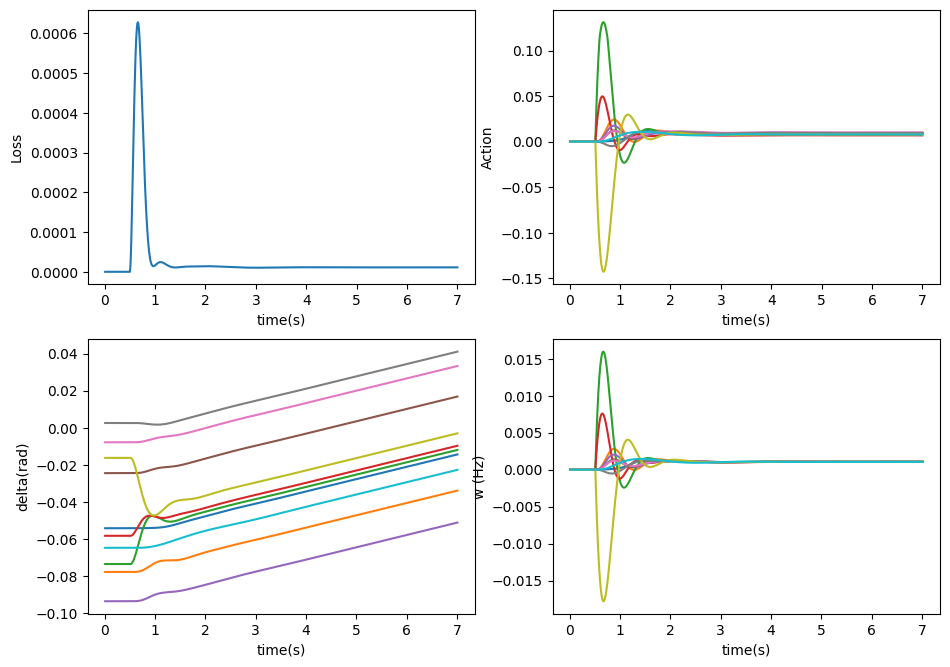

In [ ]:
# Compare the trajectory
Trajectory_RNN = [] 

gen_id = [1,2]
init_state = equilibrium_init


s = init_state.copy().astype(np.float32)
env.set_state(s)
Trajectory_RNN.append(s)
SimulationLength = 700
Record_u = []
Record_Loss = []
Loss_RNN = 0
Loss_RNN_discounted = 0
Pm_init = Pm.copy()
Pm1 = Pm_init.copy().astype(np.float32)
Pm2 = (Pm_init.copy()).astype(np.float32)
gen_id = [2,3, 8]

Pm2[0][gen_id] = 0

for i in range(SimulationLength):
    if i<int(50) or i>int(700):
      Pm_change = Pm1.copy()
    if i> = int(50) and i<int(700):
      Pm_change = Pm2.copy()

    u = np.squeeze(Action(s,layer,env))  

    next_s, r =  env.step(u,Pm_change)

    Loss_RNN_discounted+ = r
    Loss_RNN+ = r
    s = next_s
    Trajectory_RNN.append(s)
    Record_u.append(u)
    Record_Loss.append(np.squeeze(r))

print(Loss_RNN)
    
Trajectory_RNN = np.squeeze(np.asarray(Trajectory_RNN))
plt.figure(figsize = (11, 8), dpi = 100)
TimeRecord = np.arange(1,SimulationLength+1)
TimeRecord = env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(2,2,3)

TimeRecord = np.arange(1,SimulationLength+2)
TimeRecord = env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')

[[0.04432966]]


Text(0, 0.5, 'w (Hz)')

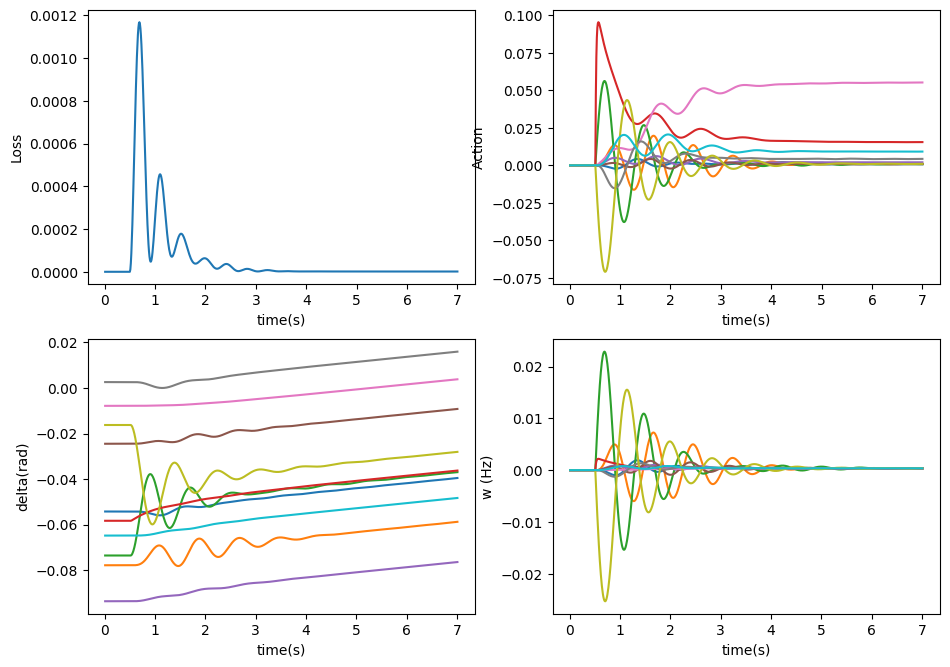

In [ ]:
# Compare the trajectory-Linear
Trajectory_RNN = [] 

gen_id = [1,2]
init_state = equilibrium_init


# init_state = env.reset()
s = init_state.copy().astype(np.float32)
env.set_state(s)
Trajectory_RNN.append(s)
SimulationLength = 700
Record_u = []
Record_Loss = []
Loss_RNN = 0
Loss_RNN_discounted = 0
Pm_init = Pm.copy()
Pm1 = Pm_init.copy().astype(np.float32)
Pm2 = (Pm_init.copy()).astype(np.float32)
gen_id = [2,3, 8]

Pm2[0][gen_id] = 0
# Pm_init[0][gen_id]*2# idx_load_increase = 2

for i in range(SimulationLength):
    # Pm = (Pm_init*np.random.uniform(0.8,1.2,(1,dim_action))).astype(np.float32)
    if i<int(50) or i>int(700):
      Pm_change = Pm1.copy()
    if i> = int(50) and i<int(700):
      Pm_change = Pm2.copy()

    u = np.squeeze(Action_linear(s,linear_coff,env)) 

    next_s, r =  env.step(u,Pm_change)

    Loss_RNN_discounted+ = r
    Loss_RNN+ = r
    s = next_s
    Trajectory_RNN.append(s)
    Record_u.append(u)
    Record_Loss.append(np.squeeze(r))

print(Loss_RNN)
    
Trajectory_RNN = np.squeeze(np.asarray(Trajectory_RNN))
plt.figure(figsize = (11, 8), dpi = 100)
TimeRecord = np.arange(1,SimulationLength+1)
TimeRecord = env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(2,2,3)

TimeRecord = np.arange(1,SimulationLength+2)
TimeRecord = env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')

# Plot action


<>:28: DeprecationWarning: invalid escape sequence \o


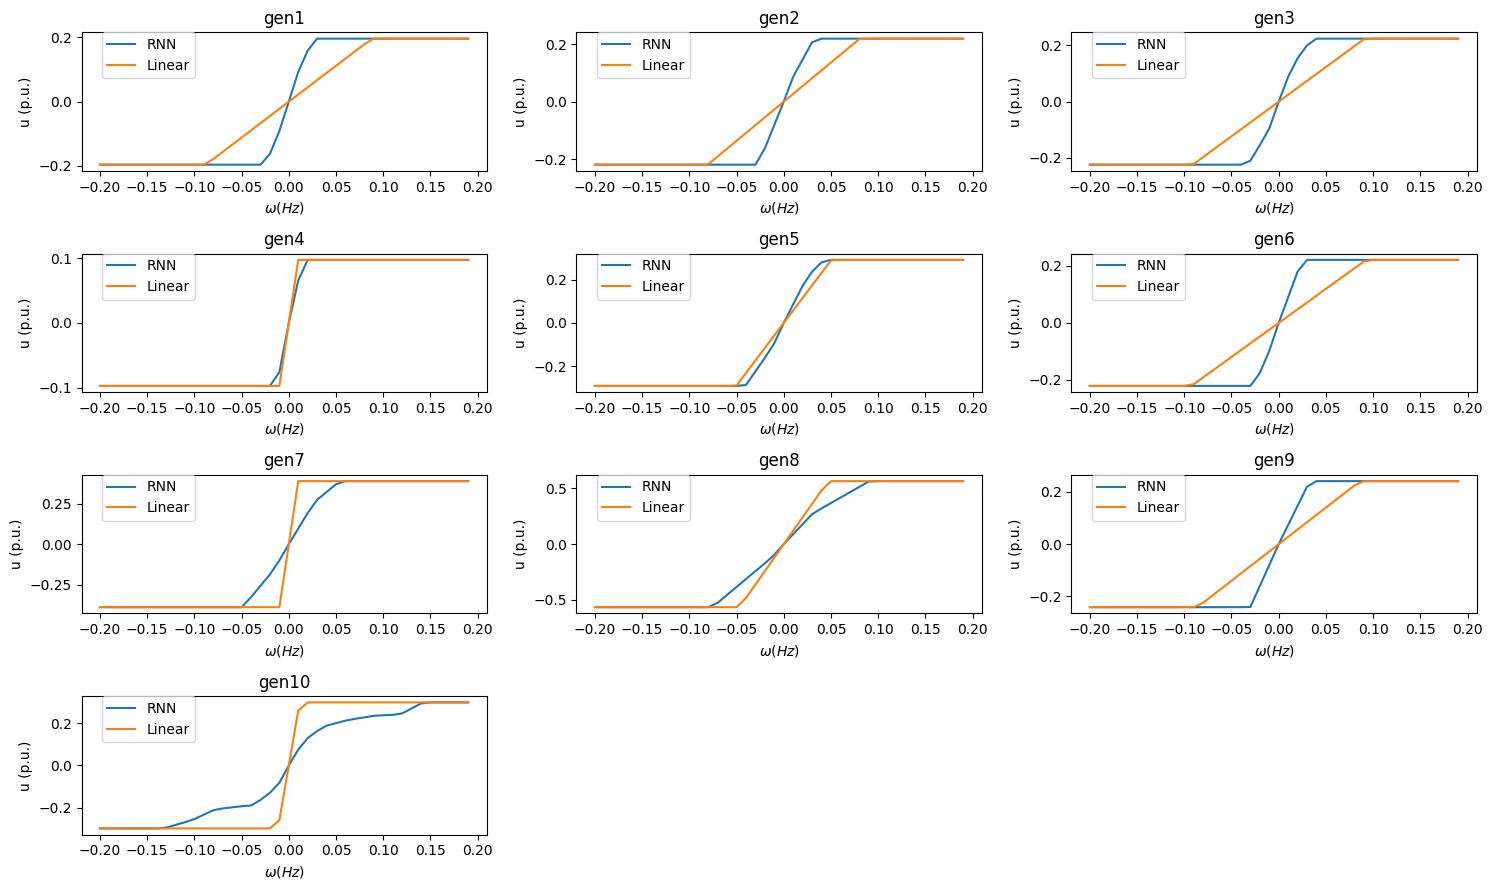

In [ ]:

initial_state1 = np.random.uniform(0.0,0.3,(1,action_units))
initial_state2 = np.random.uniform(-0.03,0.03,(1,action_units))
s_concate0 = np.hstack((initial_state1,initial_state2)).astype(np.float32)
state_d = np.float32(0.2)

state_w = np.arange(-0.2,0.2,0.01,dtype = np.float32)
state_d2 = np.float32(0.03)
state_w2 = np.float32(0.02)

action_dw = np.zeros(len(state_w))
action_dw_linear = np.zeros(len(state_w))

fig = plt.figure(figsize = (15,9), dpi = 100)
plt.subplot(2,2,1)
for idx_plot in range(action_units):
    gen_idx = idx_plot
    s_concate = copy.deepcopy(s_concate0)
    for j in range(len(state_w)):
            s_concate[0,action_units+gen_idx] = state_w[j]
            u = Action(s_concate,layer,env)
            u_linear = Action_linear(s_concate,linear_coff,env)
            action_dw[j] = u[0][gen_idx]
            action_dw_linear[j] = u_linear[0][gen_idx]
    plt.subplot(np.ceil(action_units/3),3,idx_plot+1)
    plt.plot(state_w,action_dw, label = 'RNN')
    plt.plot(state_w,action_dw_linear, label = 'Linear')
    plt.title('gen'+str(idx_plot+1))
    plt.xlabel('$\omega (Hz)$')
    plt.ylabel('u (p.u.)') 
    plt.legend(bbox_to_anchor = (0.05, 1), loc = 'upper left', borderaxespad = 0.)
fig.tight_layout()    
